# Robust Hardware-Aware Ternary Weight Networks

In this notebook, we show how checkpoints of our ternary weight networks for the different network architectures and problems can be loaded, inspected, and tested. 

Here's a list of files provided in this repository.

- `models.py` - model definitions.
- `utils.py` - helper functions for dataset loading, network testing, etc.
- `plots.py` - functions for various plots used throughout this notebook. 

The following table summarizes the models we'll be loading and testing.

| Dataset    | Architecture | Metric |
| -------- | ------- | ------- |
| MNIST (Full)  | 32C5-MP2-64C5-MP2-512FC-10FC    | 99% |
| Airline Passenger Prediction | 100LSTM1-1FC     | 99% |
| CIFAR10    | 128C3-128C3-MP2-256C3-256C3-MP2-512C3-512C3-MP2-1024FC-10FC    | XX |

## Getting Started

Let's import all necessary dependencies.

In [1]:
import os, subprocess

import torch
import torch.multiprocessing as mp

import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt

from tqdm import tqdm, trange
import json
import gdown
import zipfile

# Local imports
from models import LeNet5, VGG, LSTM
from utils import get_classification_dataset, get_regression_dataset, test_classifier, test_lstm, update_sd_by_idx, find_optimal_model_epoch
from plots import plot_metric_vs_epoch, plot_weight_histograms, plot_airline_predictions

If a GPU is present, we use it. Since we'll only be doing inference, let's just set the default device to the GPU.

In [2]:
mp.set_start_method('spawn') # needs to be done once for cuda

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
torch.set_default_device(device)

Using device: cpu


Let's define our datasets, as well as a corresponding dictionary containing `(model, num_iters, num_epochs, metric)` information for each task. `model` refers to the actual `nn.Module` class that we'll instantiate and utilize for inference.

In [3]:
datasets = ['cifar10', 'mnist', 'airline']

nets = {
        'cifar10':    (VGG, 5, 300, 'Test Accuracy (%)'),  
        'mnist':   (LeNet5, 5, 100, 'Test Accuracy (%)'),
        'airline':  (LSTM, 5, 5000, 'RMSE')
       }

Let's also specify if we want to skip certain parts of this notebook during execution (detailed in comments).

In [4]:
skip_checkpoint_download = False # whether or not model checkpoints should be downloaded
skip_checkpoint_extract = False # whether or not model checkpoints should be extracted
skip_raw_processing = False # whether or not model weights should be loaded to perform inference and gather dataset performance metrics

## Downloading Model Checkpoints

We provide training checkpoints across multiple iterations, where each model is trained from scratch, on all investigated datasets on a Google Drive: https://drive.google.com/drive/folders/1EU5_yU6jLXFH81bOwhK2m2JE74emmjRe?usp=drive_link.

Let's download the data and extract everything in appropriate directories.

In [5]:
checkpoint_url = "https://drive.google.com/drive/folders/1EU5_yU6jLXFH81bOwhK2m2JE74emmjRe?usp=drive_link" 

if not skip_checkpoint_download:
    subprocess.run(["gdown", "--fuzzy", "--folder", checkpoint_url, "-O", "./model_checkpoints"])

In [6]:
if not skip_checkpoint_extract:
    for dataset in tqdm(datasets):
        zip_file = f'model_checkpoints/{dataset}.zip'
        # extract individual checkpoints
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(f'model_checkpoints/{dataset}')
        # clean up, remove the zip files
        os.remove(zip_file)

## Inference!

Let's now prepare testing accuracy data for each case.

We iterate over datasets, iterations, epochs, and record the testing performance of the model at each point in the process.

We also record the processed accuracy dataset, so that this step doesn't have to be repeated. `skip_raw_processing` can be set accordingly to skip this step.

In [7]:
test_accs_all = {}
best_models_all = {}

if (skip_raw_processing):
  with open('./processed/test_accs_all.json','r') as json_file:
    test_accs_all = json.load(json_file)
else:
  # Let's process the raw data
  for dataset in datasets:
    
    model_class, num_iters, num_epochs, metric = nets[dataset]
    model = model_class() # instantiate the network
    
    test_accs = np.zeros((num_iters, num_epochs))

    if (dataset == 'airline'):
        test_loader, scaler, months = get_regression_dataset(dataset)
    else:
        test_loader = get_classification_dataset(dataset, device=device)
    
    for i in range(num_iters):
      print(f'\nDataset: {dataset}, Model Iteration: {i}')
      for j in trange(num_epochs):
        
        # load the state dict from checkpoint
        old_state_dict = torch.load(f"model_checkpoints/{dataset}/{i}/statedict_epoch{j}.pt", weights_only=True, map_location=device)
        new_state_dict = model.state_dict()
        update_sd_by_idx(old_state_dict, new_state_dict)
        model.load_state_dict(new_state_dict)

        if (dataset == 'airline'):
            # regression, so separate function
            rmse = test_lstm(test_loader, model, device)
            test_accs[i, j] = rmse
        else:
            acc, _ = test_classifier(test_loader, model, device)
            test_accs[i, j] = acc

    test_accs_all[dataset] = test_accs.tolist()

  # all datasets processed, let's save to avoid processing next time
  with open('./processed/test_accs_all.json','w') as fp:
      fp.write(json.dumps(test_accs_all))

## Performance Plots

Let's plot the quantitative metrics for each dataset. We calculate the best model overall, and in addition report the average +- std. across the independent training runs for each problem.


cifar10: Overall Best Test Accuracy (%) = 39.21
cifar10: (Avg. +- Std) Across Models Test Accuracy (%) = 37.8 +- 1.41

mnist: Overall Best Test Accuracy (%) = 84.65
mnist: (Avg. +- Std) Across Models Test Accuracy (%) = 83.19 +- 1.46

airline: Overall Best RMSE = 0.14603030681610107
airline: (Avg. +- Std) Across Models RMSE = 0.32 +- 0.17


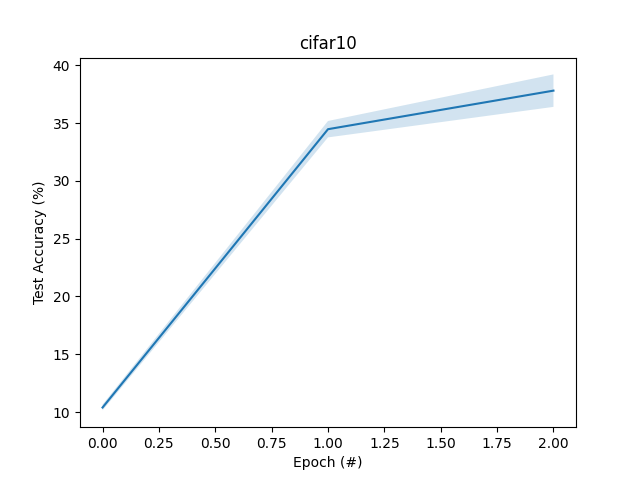

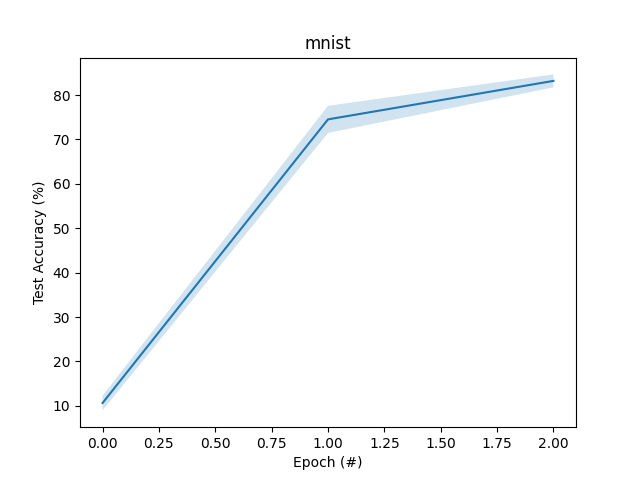

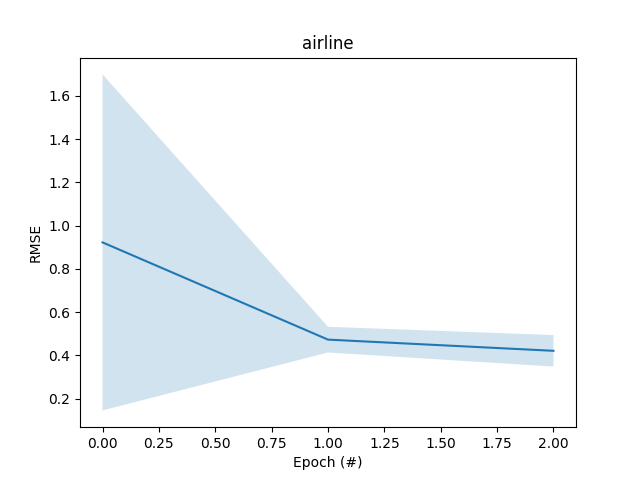

In [8]:
best_model_idxs = {}

for dataset in datasets:
    
    plot_metric_vs_epoch(test_accs_all[dataset], dataset = dataset, y_label = nets[dataset][3])
    optimal_idx = find_optimal_model_epoch(test_accs_all[dataset], dataset = dataset)
    
    best_model_idxs[dataset] = (optimal_idx[0], optimal_idx[1])
    best_metrics = optimal_idx[2]

    print(f"\n{dataset}: Overall Best {nets[dataset][3]} = {test_accs_all[dataset][optimal_idx[0]][optimal_idx[1]]}")
    print(f"{dataset}: (Avg. +- Std) Across Models {nets[dataset][3]} = {round(np.average(best_metrics), 2)} +- {round(np.std(best_metrics), 2)}")

## Weight Histograms

Let's load the best performing models for each task, and take a peek at the underlying parameter distributions.

In [9]:
best_models = {}

for dataset in datasets:
    model_class, num_iters, num_epochs, metric = nets[dataset]
    model = model_class() # instantiate the network
    
    # load the state dict from checkpoint
    i, j = best_model_idxs[dataset]
    old_state_dict = torch.load(f"model_checkpoints/{dataset}/{i}/statedict_epoch{j}.pt", weights_only=True, map_location=device)
    new_state_dict = model.state_dict()
    update_sd_by_idx(old_state_dict, new_state_dict)
    model.load_state_dict(new_state_dict)

    best_models[dataset] = model

In [10]:
best_models

{'cifar10': VGG(
   (model): Sequential(
     (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (1): ReLU()
     (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (4): ReLU()
     (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (6): ReLU()
     (7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (9): ReLU()
     (10): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (11): ReLU()
     (12): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (14): ReLU()
     (15): Flatten(start_dim=1, end_dim=-1)
     (16): Line

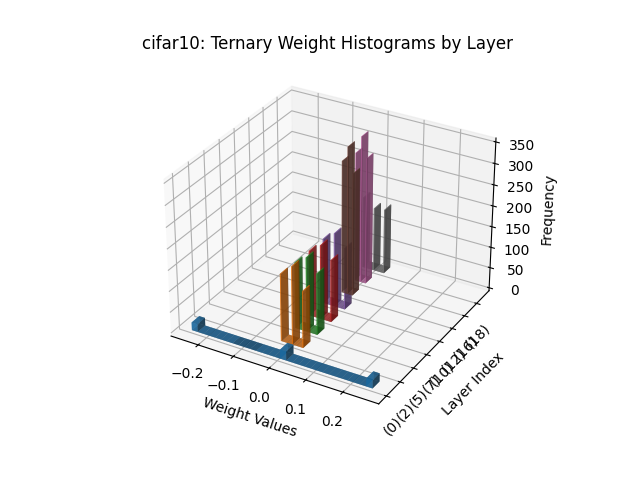

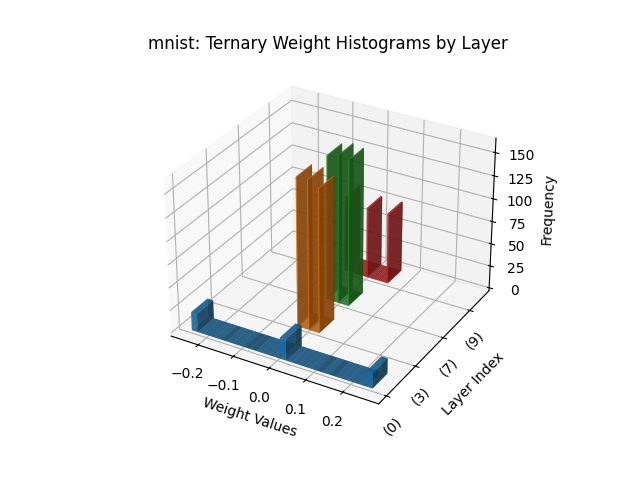

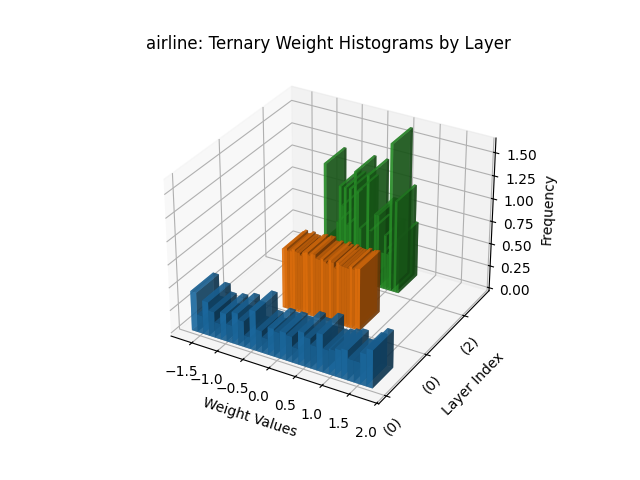

In [11]:
for dataset in datasets:
    plot_weight_histograms(best_models[dataset], dataset=dataset)

As can be seen, all layers of our models indeed have ternary weights.

For the LSTM network, we can also plot the predicted airline passengers vs. the actual airline passengers month-on-month, in order to see the network's performance.

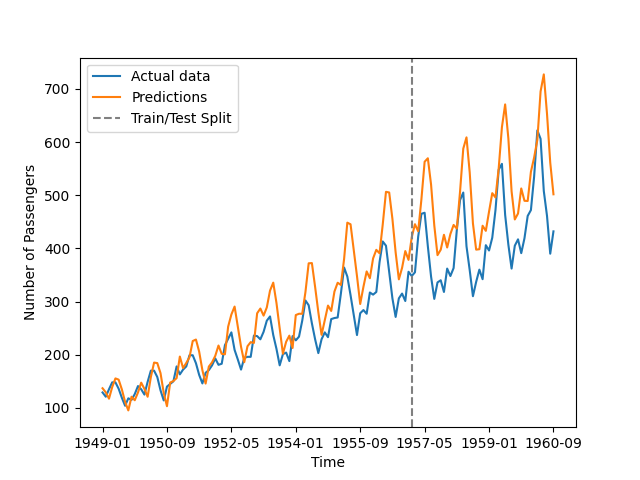

In [12]:
data_loader, scaler, months = get_regression_dataset(dataset='airline') # load dataset

all_preds, all_labels = test_lstm(data_loader, best_models['airline'], device, return_predictions=True) # extract predictions

plot_airline_predictions(scaler, all_preds, all_labels, months, subset_ticks=20) # plot!